**Deep Learning & Art: Neural Style Transfer**

In this notebook, we will implement the neural style transfer algorithm and generate novel artistic images using this algorithm. Let's start by importing the packages.

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

%matplotlib inline

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S.

In this example, you are going to generate an image of the Louvre museum in Paris (content image C), mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S).

![ ](louvre_generated.png)

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning.

Following the original NST paper (https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the earlier layers) and high level features (at the deeper layers).

In [2]:
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    #VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat' # Pick the VGG 19-layer model by from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
    #STYLE_IMAGE = 'images/stone_style.jpg' # Style image to use.
    #CONTENT_IMAGE = 'images/content300.jpg' # Content image to use.
    #OUTPUT_DIR = 'output/'

In [3]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.     
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [4]:
model = load_vgg_model("../input/pretrainedmodel/imagenet-vgg-verydeep-19.mat")
print(model)

Instructions for updating:
Colocations handled automatically by placer.
{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shap

In our running example, the content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


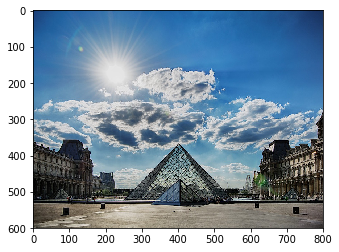

In [5]:
content_image = scipy.misc.imread("../input/nsimages/louvre.jpg")
imshow(content_image)

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds. 

The earlier (shallower) layers of a ConvNet tend to detect lower-level features such as edges and simple textures, and the later (deeper) layers tend to detect higher-level features such as more complex textures as well as object classes.

We would like the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. In practice, you'll get the most visually pleasing results if you choose a layer in the middle of the network--neither too shallow nor too deep.

So, suppose you have picked one particular hidden layer to use. Now, set the image C as the input to the pretrained VGG network, and run forward propagation. Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen.  This will be a $n_H \times n_W \times n_C$ tensor. Repeat this process with the image G: Set G as the input, and run forward progation. Let $a^{(G)}$ be the corresponding hidden layer activation. We will define as the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the volumes corresponding to a hidden layer's activations. In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below. 

![](NST_LOSS.png)

In [6]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    
    # compute the cost with tensorflow
    J_content = (1/ (4* n_H * n_W * n_C)) * tf.reduce_sum(tf.pow((a_G_unrolled - a_C_unrolled), 2))
    
    return J_content

In [7]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655935


The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. When we minimize the content cost later, this will help make sure $G$ has similar content as $C$.

For our running example, we will use the following style image:

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


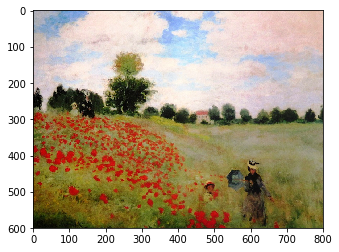

In [8]:
style_image = scipy.misc.imread("../input/nsimages/monet_800600.jpg")
imshow(style_image)

This painting was painted in the style of impressionism. Lets see how you can now define a "style" const function $J_{style}(S,G)$.

The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large.

Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature, but $G$ is used to denote the Style matrix (or Gram matrix) as well as to denote the generated image $G$. We will try to make sure which $G$ we are referring to is always clear from the context.

In NST, you can compute the Style matrix by multiplying the "unrolled" filter matrix with their transpose:

![](NST_GM.png)

The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters. The value $G_{ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$.

One important part of the gram matrix is that the diagonal elements such as $G_{ii}$ also measures how active filter $i$ is. For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{ii}$ measures how common vertical textures are in the image as a whole: If $G_{ii}$ is large, this means that the image has a lot of vertical texture. By capturing the prevalence of different types of features ($G_{ii}$), as well as how much different features occur together ($G_{ij}$), the Style matrix $G$ measures the style of an image.

In [9]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305  -4.4291224 -2.096682 ]
 [-4.4291224 19.465837  19.563871 ]
 [-2.096682  19.563871  20.686462 ]]


After generating the Style matrix (Gram matrix), your goal will be to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, and the corresponding style cost for this layer is defined as:

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$
where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.

In [11]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_H*n_W, n_C) 
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss 
    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))
    
    return J_style_layer

In [12]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190281


So far you have captured the style from only one layer. We'll get better results if we "merge" style costs from several different layers. After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$. But for now, this is a pretty reasonable default:

In [13]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$
where the values for $\lambda^{[l]}$ are given in STYLE_LAYERS.

In [14]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

The style of an image can be represented using the Gram matrix of a hidden layer's activations. However, we get even better results combining this representation from multiple different layers. This is in contrast to the content representation, where usually using just a single hidden layer is sufficient. Minimizing the style cost will cause the image $G$ to follow the style of the image $S$.


Finally, let's create a cost function that minimizes both the style and the content cost. The formula is:

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$


In [15]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style
    
    return J

In [16]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$. Here, $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style

In [17]:
def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    
    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS
    
    return image

In [18]:
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

Let's start the interactive session.

In [19]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

Let's load, reshape, and normalize our "content" image (the Louvre museum picture):

In [20]:
content_image = scipy.misc.imread("../input/nsimages/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Let's load, reshape and normalize our "style" image (Claude Monet's painting):

In [21]:
style_image = scipy.misc.imread("../input/nsimages/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Now, we initialize the "generated" image as a noisy image created from the content_image. By initializing the pixels of the generated image to be mostly noise but still slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


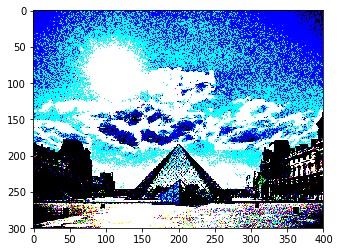

In [22]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [23]:
model = load_vgg_model("../input/pretrainedmodel/imagenet-vgg-verydeep-19.mat")

# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [24]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

Let's compute the total cost $J$ by calling total_cost() using alpha = 10 and beta = 40. Then, we set up the Adam optimizer using a learning rate of 2.

In [25]:
# compute total cost function
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

# define optimizer 
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step 
train_step = optimizer.minimize(J)

In [26]:
def save_image(image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    #scipy.misc.imsave(path,image)
    
    # Display the results in the notebook
    #output_image = scipy.misc.imread(path, image)
    imshow(image)

In [27]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
    
    # save last generated image
    save_image(generated_image)
    
    return generated_image

Iteration 0 :
total cost = 5050358300.0
content cost = 7877.6377
style cost = 126256984.0
Iteration 20 :
total cost = 943350460.0
content cost = 15187.984
style cost = 23579964.0
Iteration 40 :
total cost = 484977250.0
content cost = 16784.145
style cost = 12120235.0
Iteration 60 :
total cost = 312613800.0
content cost = 17467.553
style cost = 7810978.0
Iteration 80 :
total cost = 228234940.0
content cost = 17721.057
style cost = 5701443.0
Iteration 100 :
total cost = 180779260.0
content cost = 17900.908
style cost = 4515006.5
Iteration 120 :
total cost = 150041060.0
content cost = 18039.04
style cost = 3746516.8
Iteration 140 :
total cost = 127778040.0
content cost = 18188.752
style cost = 3189903.8
Iteration 160 :
total cost = 110734960.0
content cost = 18345.715
style cost = 2763787.5
Iteration 180 :
total cost = 97385500.0
content cost = 18489.74
style cost = 2430015.2


array([[[[ -48.11287  ,  -61.26624  ,   48.930614 ],
         [ -26.759687 ,  -40.43193  ,   27.147415 ],
         [ -42.143322 ,  -28.953827 ,   11.362922 ],
         ...,
         [ -26.251114 ,   -9.433574 ,   14.353281 ],
         [ -29.387697 ,   -2.8154888,   24.092901 ],
         [ -40.841213 ,   -3.6455984,   49.71605  ]],

        [[ -61.785385 ,  -51.666164 ,   25.526157 ],
         [ -33.29016  ,  -31.055595 ,   -1.4363692],
         [ -27.388815 ,  -30.718004 ,   15.190694 ],
         ...,
         [ -26.58931  ,   -6.532113 ,   25.279297 ],
         [ -21.156927 ,  -18.064075 ,   12.820547 ],
         [ -40.152466 ,   -7.559675 ,    8.484435 ]],

        [[ -52.65466  ,  -51.63161  ,   13.706686 ],
         [ -37.400826 ,  -41.494022 ,   -6.2745767],
         [ -34.414883 ,  -25.380577 ,    7.3784566],
         ...,
         [ -10.889158 ,  -38.78363  ,   12.091046 ],
         [ -12.312371 ,  -21.87224  ,   16.662199 ],
         [ -22.553188 ,  -19.531733 ,   13.528356 ]],

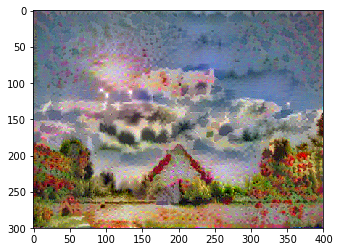

In [28]:
model_nn(sess, generated_image)